# HEART DISEASE DETECTION PROJECT - ADVANCED VERSION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv("cleaned_merged_heart_dataset.csv")
print(f"Dataset Loaded: {data.shape}")

X = data.drop('target', axis=1)
y = data['target']


Dataset Loaded: (1888, 14)


In [3]:
print(data.head())


   age  sex  cp  trestbps  chol  fbs  restecg  thalachh  exang  oldpeak  \
0   63    1   3       145   233    1        0       150      0      2.3   
1   37    1   2       130   250    0        1       187      0      3.5   
2   41    0   1       130   204    0        0       172      0      1.4   
3   56    1   1       120   236    0        1       178      0      0.8   
4   57    0   0       120   354    0        1       163      1      0.6   

   slope  ca  thal  target  
0      0   0     1       1  
1      0   0     2       1  
2      2   0     2       1  
3      2   0     2       1  
4      2   0     2       1  


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1888 non-null   int64  
 1   sex       1888 non-null   int64  
 2   cp        1888 non-null   int64  
 3   trestbps  1888 non-null   int64  
 4   chol      1888 non-null   int64  
 5   fbs       1888 non-null   int64  
 6   restecg   1888 non-null   int64  
 7   thalachh  1888 non-null   int64  
 8   exang     1888 non-null   int64  
 9   oldpeak   1888 non-null   float64
 10  slope     1888 non-null   int64  
 11  ca        1888 non-null   int64  
 12  thal      1888 non-null   int64  
 13  target    1888 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 206.6 KB


In [5]:
print(data.describe())

               age          sex           cp     trestbps         chol  \
count  1888.000000  1888.000000  1888.000000  1888.000000  1888.000000   
mean     54.354343     0.688559     1.279131   131.549258   246.855403   
std       9.081505     0.463205     1.280877    17.556985    51.609329   
min      29.000000     0.000000     0.000000    94.000000   126.000000   
25%      47.750000     0.000000     0.000000   120.000000   211.000000   
50%      55.000000     1.000000     1.000000   130.000000   241.000000   
75%      61.000000     1.000000     2.000000   140.000000   276.000000   
max      77.000000     1.000000     4.000000   200.000000   564.000000   

               fbs      restecg     thalachh        exang      oldpeak  \
count  1888.000000  1888.000000  1888.000000  1888.000000  1888.000000   
mean      0.148305     0.597458   149.424258     0.331568     1.053761   
std       0.355496     0.638820    23.006153     0.470901     1.161344   
min       0.000000     0.000000    71

In [6]:
# Count the number of patients with and without heart disease
target_counts = data['target'].value_counts()

print("Target Variable Distribution (Class Imbalance)")
print(target_counts)


Target Variable Distribution (Class Imbalance)
target
1    977
0    911
Name: count, dtype: int64


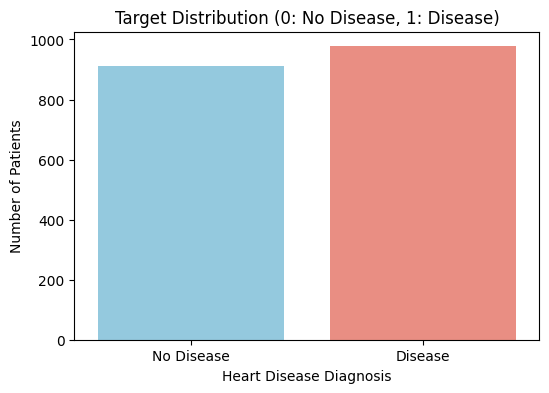

In [7]:
# Visualize the class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette=['skyblue', 'salmon'])
plt.title('Target Distribution (0: No Disease, 1: Disease)')
plt.xlabel('Heart Disease Diagnosis')
plt.ylabel('Number of Patients')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.show()


Distribution of Key Numerical Features


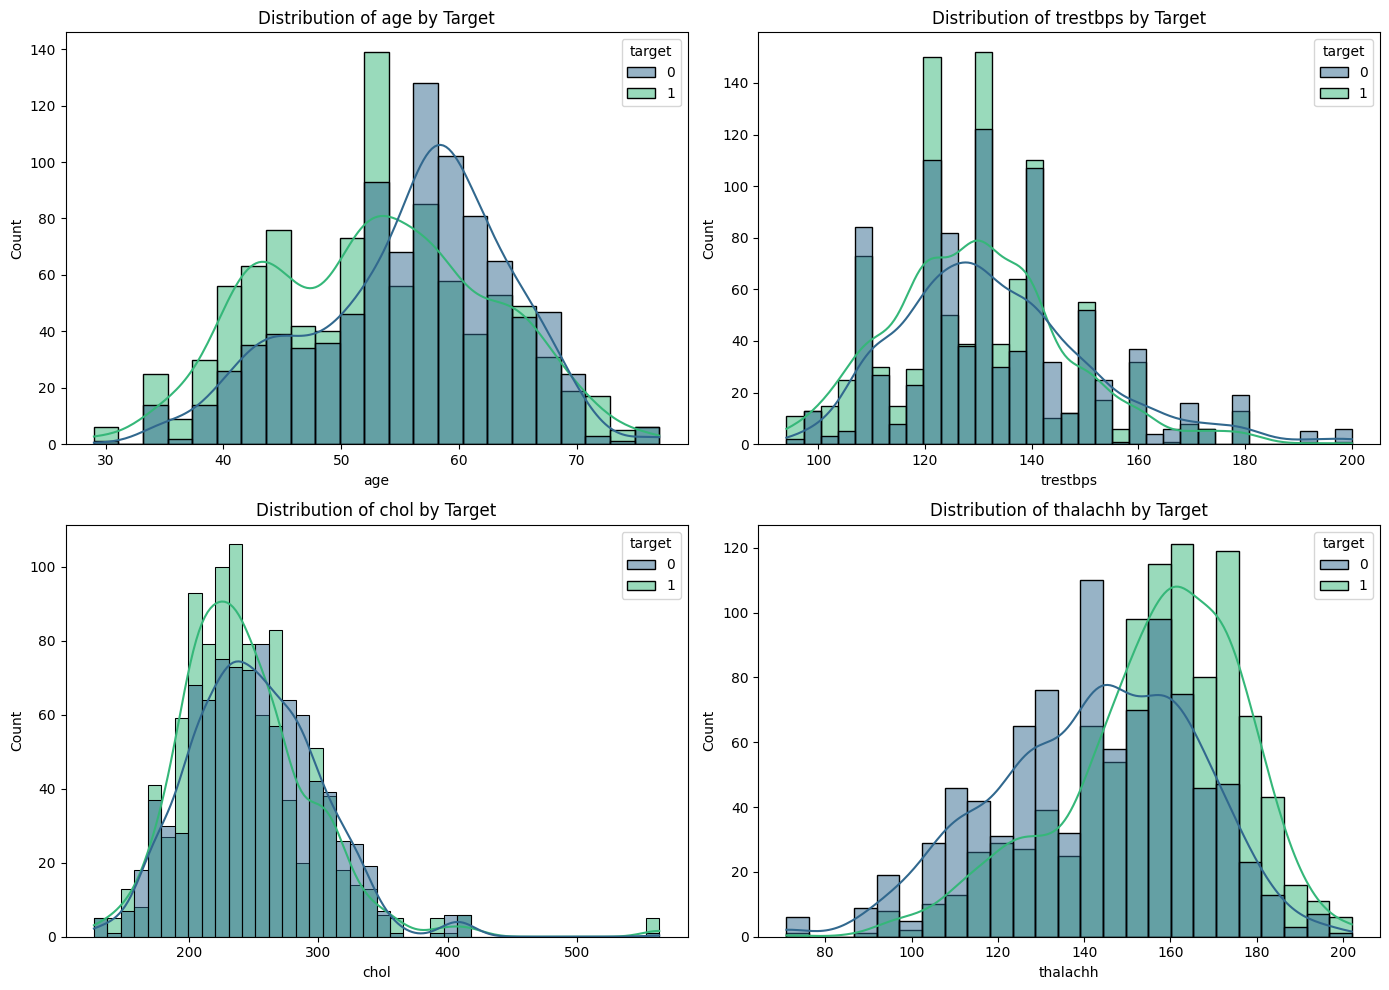

In [8]:
continuous_features = ['age', 'trestbps', 'chol', 'thalachh']

print("Distribution of Key Numerical Features")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(continuous_features):
    sns.histplot(data=data, x=col, hue='target', kde=True, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {col} by Target')

plt.tight_layout()
plt.show()


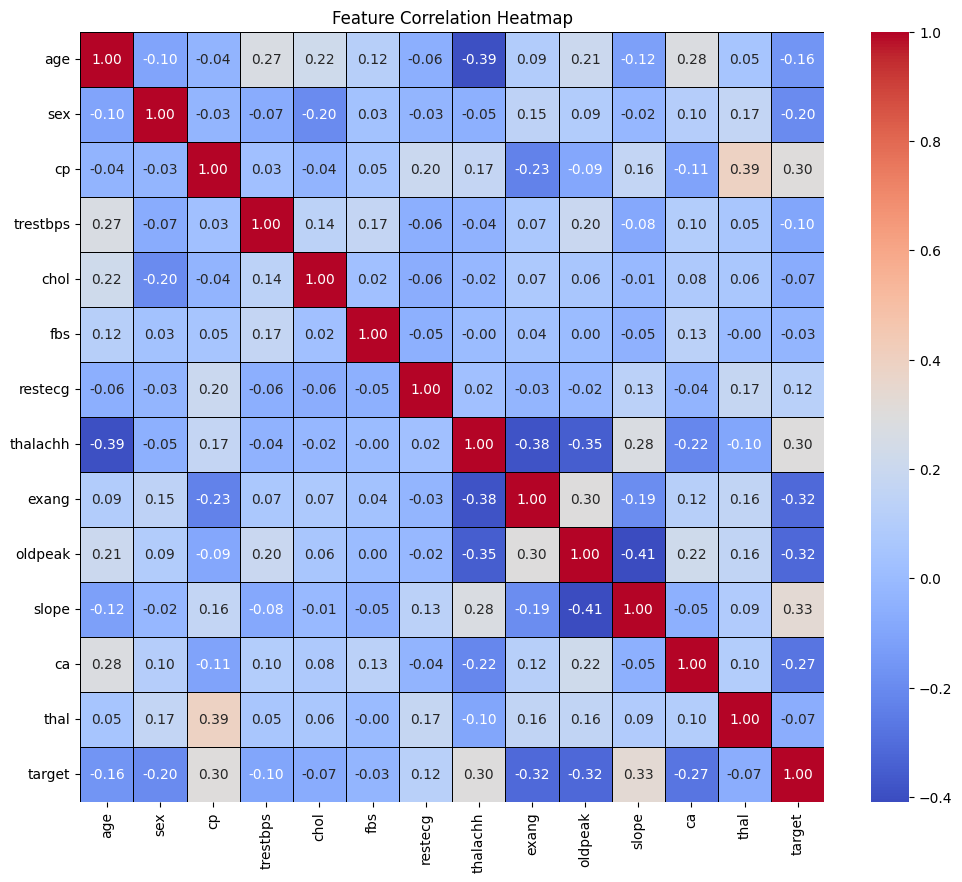


--- 6. Correlation with Target Variable ---
target      1.000000
slope       0.333837
cp          0.304025
thalachh    0.298795
restecg     0.123289
fbs        -0.032491
thal       -0.067322
chol       -0.071589
trestbps   -0.095875
age        -0.162303
sex        -0.196214
ca         -0.273105
exang      -0.315084
oldpeak    -0.315629
Name: target, dtype: float64


In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, linecolor='black')
plt.title('Feature Correlation Heatmap')
plt.show()

print("\nCorrelation with Target Variable")
print(correlation_matrix['target'].sort_values(ascending=False))


In [10]:
# Preprocessing

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

joblib.dump(scaler, "scaler.pkl")



['scaler.pkl']

In [11]:
# Define Models + Hyperparameters

models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {"C": [0.1, 1, 10]}),
    "Random Forest": (RandomForestClassifier(random_state=42), {"n_estimators": [100, 200]}),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {"n_estimators": [100, 200]}),
    "XGBoost": (XGBClassifier(eval_metric='logloss', random_state=42), {"n_estimators": [100, 200]}),
    "SVM": (SVC(probability=True), {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"]}),
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9]})
}


In [12]:
# Train Models + Evaluate with Cross-Validation

results = []
best_models = {}

for name, (model, params) in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_models[name] = best_model

    mean_cv_score = grid.cv_results_['mean_test_score'][grid.best_index_]
    std_cv_score = grid.cv_results_['std_test_score'][grid.best_index_]
    print(f"Best CV Accuracy: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "CV Accuracy Mean": mean_cv_score,
        "CV Std": std_cv_score,
        "Test Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    })

results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print("\nModel Results with CV")
print(results_df)





Training Logistic Regression...
Best CV Accuracy: 0.7497 ± 0.0419

Training Random Forest...
Best CV Accuracy: 0.9656 ± 0.0100

Training Gradient Boosting...
Best CV Accuracy: 0.9364 ± 0.0077

Training XGBoost...
Best CV Accuracy: 0.9563 ± 0.0057

Training SVM...
Best CV Accuracy: 0.9384 ± 0.0095

Training KNN...
Best CV Accuracy: 0.9384 ± 0.0173

Model Results with CV
                 Model  CV Accuracy Mean    CV Std  Test Accuracy  Precision  \
1        Random Forest          0.965563  0.009956       0.981481   0.974874   
3              XGBoost          0.956291  0.005697       0.976190   0.965174   
2    Gradient Boosting          0.936424  0.007666       0.952381   0.954082   
4                  SVM          0.938411  0.009505       0.933862   0.917073   
5                  KNN          0.938411  0.017345       0.944444   0.910798   
0  Logistic Regression          0.749669  0.041864       0.748677   0.724444   

     Recall        F1       AUC  
1  0.989796  0.982278  0.999047 

In [13]:
# Save All Models Using Joblib
for name, model in best_models.items():
    file_name = f"{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, file_name)

best_model_name = results_df.iloc[0]["Model"]
best_model = best_models[best_model_name]
joblib.dump(best_model, "best_heart_model.pkl")
print(f"\n✅ Best Model Saved: {best_model_name}")




✅ Best Model Saved: Random Forest


In [14]:
# Visualize CV vs Test Accuracy

plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["CV Accuracy Mean"], alpha=0.6, label='CV Accuracy')
plt.bar(results_df["Model"], results_df["Test Accuracy"], alpha=0.6, label='Test Accuracy')
plt.title("Cross-Validation vs Test Accuracy by Model")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("cv_vs_test_accuracy.png")
plt.close()



In [15]:
# ROC Curve Comparison
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("roc_comparison.png")
plt.close()



In [ ]:
# SHAP Explainability (Using XGBoost)
print("Calculating SHAP values...")
xgb_model = best_models["XGBoost"]

# Use the model and the dataframe X_test
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
joblib.dump(shap_values, "shap_values.pkl")



Calculating SHAP values...


['shap_values.pkl']

In [17]:
# SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png")
plt.close()


In [18]:
# SHAP bar plot
plt.figure()
shap.plots.bar(shap_values, show=False)
plt.tight_layout()
plt.savefig("shap_bar.png")
plt.close()

In [19]:
# Error and High-Error Analysis
y_pred_final = best_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("conf_matrix.png")
plt.close()

# Misclassified samples
test_df = pd.DataFrame(X_test, columns=X.columns)
test_df["Actual"] = y_test.values
test_df["Predicted"] = y_pred_final
errors = test_df[test_df["Actual"] != test_df["Predicted"]]
joblib.dump(errors, "error_samples.pkl")

print(f"\nMisclassified samples: {len(errors)} / {len(y_test)}")




Misclassified samples: 7 / 378
